In [1]:
# Importing the packages
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from scipy import stats as st
%matplotlib inline

In [2]:
df = pd.read_csv('../Backorder_clean.csv')
df.head()

,product_id,current_inventory,transit_duration,prior_sales_1_month,prior_sales_3_month,prior_sales_6_month,prior_sales_9_month,minimum_recommended_stock,source_performance_6_months,source_performance_12_months,deck_risk,ppap_risk,stop_auto_buy,went_on_backorder
0,1026827,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.84,0.83,No,No,Yes,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.99,0.99,No,No,Yes,No
2,1043696,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.84,0.83,Yes,No,Yes,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,1.0,0.10,0.13,No,No,Yes,No
4,1044048,8.0,8.0,0.0,0.0,0.0,4.0,2.0,0.84,0.83,Yes,No,Yes,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1639734 entries, 0 to 1639733
Data columns (total 14 columns):
product_id                      1639734 non-null int64
current_inventory               1639734 non-null float64
transit_duration                1639734 non-null float64
prior_sales_1_month             1639734 non-null float64
prior_sales_3_month             1639734 non-null float64
prior_sales_6_month             1639734 non-null float64
prior_sales_9_month             1639734 non-null float64
minimum_recommended_stock       1639734 non-null float64
source_performance_6_months     1639734 non-null float64
source_performance_12_months    1639734 non-null float64
deck_risk                       1639734 non-null object
ppap_risk                       1639734 non-null object
stop_auto_buy                   1639734 non-null object
went_on_backorder               1639734 non-null object
dtypes: float64(9), int64(1), object(4)
memory usage: 175.1+ MB


In [4]:
sourceperf_corr_df = df[['source_performance_6_months','source_performance_12_months']]
sourceperf_corr = sourceperf_corr_df.corr()
sourceperf_corr

,source_performance_6_months,source_performance_12_months
source_performance_6_months,1.000000,0.944819
source_performance_12_months,0.944819,1.000000


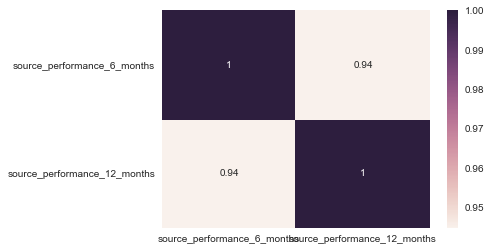

In [5]:
_ = sns.heatmap(sourceperf_corr, annot=True)

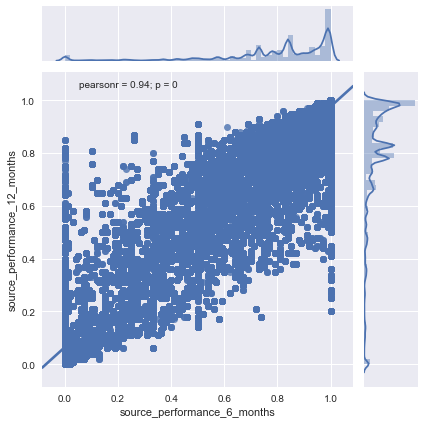

In [6]:
_=sns.jointplot('source_performance_6_months', 'source_performance_12_months', data=df, kind='reg')

We can see that, as expected,performace over 6 and 12 month periods are highly correlated too.

In [7]:
sales_corr_df = df[['prior_sales_1_month','prior_sales_3_month','prior_sales_6_month','prior_sales_9_month']]
sales_corr = sales_corr_df.corr()
sales_corr

,prior_sales_1_month,prior_sales_3_month,prior_sales_6_month,prior_sales_9_month
prior_sales_1_month,1.000000,0.908458,0.870974,0.832273
prior_sales_3_month,0.908458,1.000000,0.988823,0.955235
prior_sales_6_month,0.870974,0.988823,1.000000,0.973371
prior_sales_9_month,0.832273,0.955235,0.973371,1.000000


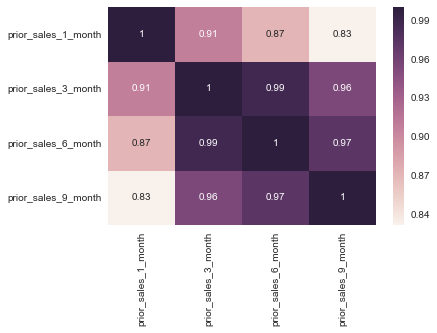

In [8]:
_=sns.heatmap(sales_corr, annot=True)

Similarly, these prior sales over the periods of 3, 6 and 9 months are highly correlated.

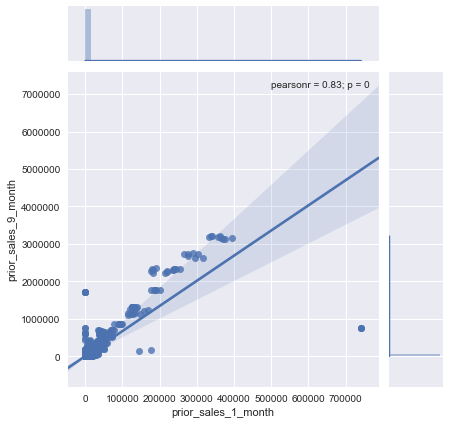

In [9]:
_=sns.jointplot('prior_sales_1_month', 'prior_sales_9_month', data=df, kind='reg')

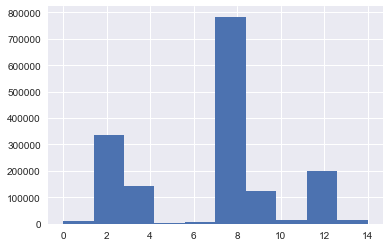

In [10]:
_ = plt.hist(df.transit_duration)

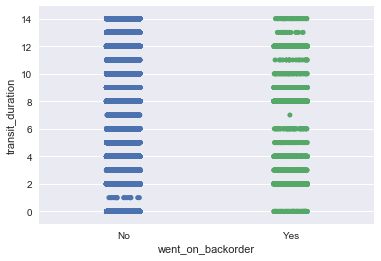

In [11]:
sns.stripplot(x='went_on_backorder', y='transit_duration', data=df, jitter=True);

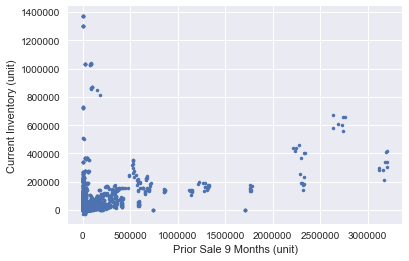

In [13]:
plt.plot(df.prior_sales_9_month, df.current_inventory, marker='.', linestyle='None')
plt.xlabel('Prior Sale 9 Months (unit)')
plt.ylabel('Current Inventory (unit)')

It would be interesting to find out why the current inventory for some products is as high as 1.4 Million even when there is no sale in prior 9 months. This could even be a question to client. It could be a bad data as well.

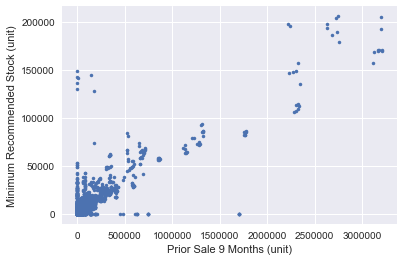

In [14]:
plt.plot(df.prior_sales_9_month, df.minimum_recommended_stock, marker='.', linestyle='None')
plt.xlabel('Prior Sale 9 Months (unit)')
plt.ylabel('Minimum Recommended Stock (unit)')

Another observation around the recommended stock where we can see that prior sales were zero, however, the minimum recommended stock is kept at a high value of 125k+. It could be a bad data or potential outliers.

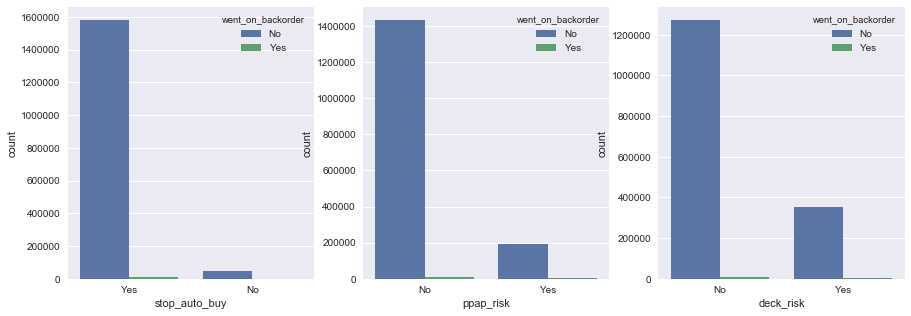

In [17]:
fig , ax = plt.subplots(ncols=3, figsize=(15,5))
sns.countplot('stop_auto_buy',hue='went_on_backorder', data=df, ax=ax[0])
sns.countplot('ppap_risk', hue='went_on_backorder', data=df, ax=ax[1])
sns.countplot('deck_risk', hue='went_on_backorder', data=df, ax=ax[2])

In [19]:
df['deck_risk_n']= df.deck_risk.map({'Yes':1,'No':0})
df['ppap_risk_n']= df.ppap_risk.map({'Yes':1,'No':0})
df['stop_auto_buy_n']= df.stop_auto_buy.map({'Yes':1,'No':0})
df['went_on_backorder_n']= df.went_on_backorder.map({'Yes':1,'No':0})

Look's like deck_risk,stop_auto_buy and ppap_risk has some realtion with went_on_backorder. Let's find out using **crosstabulation and chi-square**

For a chi-square test for association, the hypotheses are as follows:

**Ho==> Features are indepnedent, no association between variables exists.**

**H1==> Features are not independent; an association between variables exist.**


In [21]:
# ppap_risk relation with went_on_backorder
contingency_table_ppasrisk = pd.crosstab(df.ppap_risk, df.went_on_backorder)
contingency_table_ppasrisk.columns = ['No','Yes']
contingency_table_ppasrisk.index = ['No','Yes']
contingency_table_ppasrisk

,No,Yes
No,1434423,9447
Yes,194123,1741


In [22]:
chi_ppasrisk , p_val_ppasrisk , dof_ppasrisk , exp_ppasrisk  = st.chi2_contingency(contingency_table_ppasrisk )
chi2_critical_ppasrisk = st.chi2.ppf(q = 0.95, df = dof_ppasrisk)
print("Chi-square Critical value:", chi2_critical_ppasrisk)
print('chi2 :', chi_ppasrisk)
print('p_val:', p_val_ppasrisk)
print('degree of freedom:', dof_ppasrisk)

Chi-square Critical value: 3.84145882069
chi2 : 139.727268768
p_val: 3.05389542615e-32
degree of freedom: 1


In [23]:
# stop_auto_buy relation  with went_on_backorder
contingency_table_stop_auto_buy = pd.crosstab(df.stop_auto_buy, df.went_on_backorder)
contingency_table_stop_auto_buy.columns = ['No','Yes']
contingency_table_stop_auto_buy.index = ['No','Yes']
contingency_table_stop_auto_buy

,No,Yes
No,46977,444
Yes,1581569,10744


In [24]:
chi2_stop_auto_buy, p_val_stop_auto_buy, dof_stop_auto_buy, exp_stop_auto_buy = st.chi2_contingency(contingency_table_stop_auto_buy)
chi2_critical_stop_auto_buy = st.chi2.ppf(q = 0.95, df = dof_stop_auto_buy)
print("Chi-square Critical value:", chi2_critical_stop_auto_buy)
print('chi2:', chi2_stop_auto_buy)
print('p_val:', p_val_stop_auto_buy)
print('degree of freedom:', dof_stop_auto_buy)

Chi-square Critical value: 3.84145882069
chi2: 46.1024466233
p_val: 1.12228215964e-11
degree of freedom: 1


In [26]:
# deck_risk has relation with went_on_backorder
contingency_table_deck_risk = pd.crosstab(df.deck_risk, df.went_on_backorder)
contingency_table_deck_risk.columns = ['No','Yes']
contingency_table_deck_risk.index = ['No','Yes']
contingency_table_deck_risk

,No,Yes
No,1273264,9299
Yes,355282,1889


In [30]:
chi2, p_vl, dof, exp = st.chi2_contingency(contingency_table_deck_risk )
chi2_critical = st.chi2.ppf(q = 0.95, df = dof)
print("Chi-square Critical value:", chi2_critical)
print('chi2:', chi2)
print('p_val:', p_vl)
print('degree of freedom:', dof)

Chi-square Critical value: 3.84145882069
chi2: 158.335589328
p_val: 2.61404804663e-36
degree of freedom: 1


We used crosstabulation and chi-square to find the relation between target variable with other categorical variables. All the relations has p-values is less than 0.05 and we also have chi-square calculated value is greater than the chi-square critical value. Based on these two evidence we can reject the null hypothesis and can go with the alternate hypothesis. 

Here we can say that  went_on_backorder is related to deck_risk,ppap_risk and stop_auto_buy, so we will keep all these features for modeling.
